In [1]:
import bacco
import numpy as np
import matplotlib.pyplot as plt
import pickle5 as pickle
import sys,os,h5py,hdf5plugin

bacco.plotting.set_defaults(useTex=False)

# readgadget

In [13]:
# This library is designed to read Gadget format I, format II and hdf5 files
import numpy as np
import readsnap

# find snapshot name and format
def fname_format(snapshot):
    if os.path.exists(snapshot):
        if snapshot[-4:]=='hdf5':  filename, fformat = snapshot, 'hdf5'
        else:                      filename, fformat = snapshot, 'binary'
    elif os.path.exists(snapshot+'.0'):
        filename, fformat = snapshot+'.0', 'binary'
    elif os.path.exists(snapshot+'.hdf5'):
        filename, fformat = snapshot+'.hdf5', 'hdf5'
    elif os.path.exists(snapshot+'.0.hdf5'):
        filename, fformat = snapshot+'.0.hdf5', 'hdf5'
    else:  raise Exception('File not found!')
    return filename,fformat


# This class reads the header of the gadget file
class header:
    def __init__(self, snapshot):

        filename, fformat = fname_format(snapshot)

        if fformat=='hdf5':
            f             = h5py.File(filename, 'r')
            
            self.time     = f['Header'].attrs[u'Time']
            self.redshift = f['Header'].attrs[u'Redshift']
            self.npart    = (f['Header'].attrs[u'NumPart_ThisFile']).astype(np.int64)
            self.nall     = (f['Header'].attrs[u'NumPart_Total']).astype(np.int64)
            self.filenum  = int(f['Header'].attrs[u'NumFilesPerSnapshot'])
            self.massarr  = f['Header'].attrs[u'MassTable']
            self.boxsize  = f['Header'].attrs[u'BoxSize']

            # check if it is a SWIFT snapshot
            if '/Cosmology' in f.keys():
                self.omega_m  = f['Cosmology'].attrs[u'Omega_m']
                self.omega_l  = f['Cosmology'].attrs[u'Omega_lambda']
                self.hubble   = f['Cosmology'].attrs[u'h']

            # check if it is a Gadget-4 snapshot
            elif '/Parameters' in f.keys():
                self.omega_m  = f['Parameters'].attrs[u'Omega0']
                self.omega_l  = f['Parameters'].attrs[u'OmegaLambda']
                self.hubble   = f['Parameters'].attrs[u'HubbleParam']
                #self.cooling  = f['Parameters'].attrs[u'Flag_Cooling']

            # if it is a traditional Gadget-1/2/3 snapshot
            else:
                self.omega_m  = f['Header'].attrs[u'Omega0']
                self.omega_l  = f['Header'].attrs[u'OmegaLambda']
                self.hubble   = f['Header'].attrs[u'HubbleParam']
                #self.cooling  = f['Header'].attrs[u'Flag_Cooling']

            self.format   = 'hdf5'
            f.close()

        else:        
            head = readsnap.snapshot_header(filename)
            self.time     = head.time
            self.redshift = head.redshift
            self.boxsize  = head.boxsize
            self.filenum  = head.filenum
            self.omega_m  = head.omega_m
            self.omega_l  = head.omega_l
            self.hubble   = head.hubble
            self.massarr  = head.massarr
            self.npart    = head.npart
            self.nall     = head.nall
            self.cooling  = head.cooling
            self.format   = head.format

        # km/s/(Mpc/h)
        self.Hubble = 100.0*np.sqrt(self.omega_m*(1.0+self.redshift)**3+self.omega_l)


# This function reads a block of an individual file of a gadget snapshot
def read_field(snapshot, block, ptype):

    filename, fformat = fname_format(snapshot)
    head              = header(filename)
    Masses            = head.massarr*1e10 #Msun/h                  
    Npart             = head.npart        #number of particles in the subfile
    Nall              = head.nall         #total number of particles in the snapshot
    
    if fformat=="binary":
        return readsnap.read_block(filename, block, parttype=ptype)
    else:
        prefix = 'PartType%d/'%ptype
        f = h5py.File(filename, 'r')
        if   block=="POS ":  suffix = "Coordinates"
        elif block=="MASS":  suffix = "Masses"
        elif block=="ID  ":  suffix = "ParticleIDs"
        elif block=="VEL ":  suffix = "Velocities"
        else: raise Exception('block not implemented in readgadget!')

        if '%s%s'%(prefix,suffix) not in f.keys():
            if Masses[ptype] != 0.0:
                array = np.ones(Npart[ptype], np.float32)*Masses[ptype]
            else:
                raise Exception('Problem reading the block %s'%block)
        else:
            array = f[prefix+suffix][:]
        f.close()

        if block=="VEL ":  array *= np.sqrt(head.time)
        if block=="POS " and array.dtype==np.float64:
            array = array.astype(np.float32)

        return array

# This function reads a block from an entire gadget snapshot (all files)
# it can read several particle types at the same time. 
# ptype has to be a list. E.g. ptype=[1], ptype=[1,2], ptype=[0,1,2,3,4,5]
def read_block(snapshot, block, ptype, verbose=False):

    # find the format of the file and read header
    filename, fformat = fname_format(snapshot)
    head    = header(filename)    
    Nall    = head.nall
    filenum = head.filenum

    # find the total number of particles to read
    Ntotal = 0
    for i in ptype:
        Ntotal += Nall[i]

    # find the dtype of the block
    if   block=="POS ":  dtype=np.dtype((np.float32,3))
    elif block=="VEL ":  dtype=np.dtype((np.float32,3))
    elif block=="MASS":  dtype=np.float32
    elif block=="ID  ":  dtype=read_field(filename, block, ptype[0]).dtype
    else: raise Exception('block not implemented in readgadget!')

    # define the array containing the data
    array = np.zeros(Ntotal, dtype=dtype)


    # do a loop over the different particle types
    offset = 0
    for pt in ptype:

        # format I or format II Gadget files
        if fformat=="binary":
            array[offset:offset+Nall[pt]] = \
                readsnap.read_block(snapshot, block, pt, verbose=verbose)
            offset += Nall[pt]

        # single files (either binary or hdf5)
        elif filenum==1:
            array[offset:offset+Nall[pt]] = read_field(snapshot, block, pt)
            offset += Nall[pt]

        # multi-file hdf5 snapshot
        else:

            # do a loop over the different files
            for i in range(filenum):
                
                # find the name of the file to read
                filename = '%s.%d.hdf5'%(snapshot,i)

                # read number of particles in the file and read the data
                npart = header(filename).npart[pt]
                array[offset:offset+npart] = read_field(filename, block, pt)
                offset += npart   

    if offset!=Ntotal:  raise Exception('not all particles read!!!!')
            
    return array

# Loading Quijote

## Comparison Low and High res

In [4]:

qsim, ngrid, ic_type = "663", 512, "gadget2"
sim_LR = bacco.Simulation(basedir="/dipc/reangulo/tmp/{0}/".format(qsim), ngenic_phases=True, phase_type=1,
                       dm_file="snapdir_004/snap_004", sim_format="gadget_hdf5", phase=0.00, fixedPk=False, UnitLength_in_cm=3.085678e+21,
                       ns=0.960700, sigma8=0.831100, seed=663, hubble=0.701500, omega_baryon=0.046250, tau=0.0952, timebegin=0.0078125)
pksim_LR = sim_LR.get_Power(kmin=0.01, kmax=1, nbins=50, log_binning=True, deposit_method='cic')


qsim, ngrid, ic_type = "663_HR", 1024, "gadget_hdf5"
sim_HR = bacco.Simulation(basedir="/dipc/reangulo/tmp/{0}/".format(qsim), ngenic_phases=True, phase_type=1,
                       dm_file="snapdir_004/snap_004", sim_format="gadget_hdf5", phase=0.00, fixedPk=False, UnitLength_in_cm=3.085678e+21,
                       ns=0.960700, sigma8=0.831100, seed=663, hubble=0.701500, omega_baryon=0.046250, tau=0.0952, timebegin=0.0078125)
pksim_HR = sim_HR.get_Power(kmin=0.01, kmax=1, nbins=50, log_binning=True, deposit_method='cic')



2024-08-16 12:18:31,938 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 12:18:31,939 bacco.sims : Initialising simulation Default
2024-08-16 12:18:31,940 bacco.sims : try /dipc/reangulo/tmp/663/snapdir_004/snap_004
2024-08-16 12:18:32,005 bacco.sims : Loading /dipc/reangulo/tmp/663/snapdir_004/snap_004
2024-08-16 12:18:32,009 bacco.cosmo :    initialization took 0.000 secs
2024-08-16 12:18:32,063 bacco.sims : ...done in 0.0716 s
2024-08-16 12:18:32,064 bacco.sims : Computing  P(k)
2024-08-16 12:18:32,070 bacco.sims : Read data for 16934774/134217728 particles...


/dipc/reangulo/tmp/663/snapdir_004/snap_004.0.hdf5


2024-08-16 12:18:32,849 bacco.sims : Read data for 16934774/134217728 particles...
2024-08-16 12:18:32,889 bacco.sims : Read data for 16755040/134217728 particles...
2024-08-16 12:18:33,546 bacco.sims : Read data for 16755040/134217728 particles...
2024-08-16 12:18:33,571 bacco.sims : Read data for 16786319/134217728 particles...
2024-08-16 12:18:34,210 bacco.sims : Read data for 16786319/134217728 particles...
2024-08-16 12:18:34,263 bacco.sims : Read data for 16710594/134217728 particles...
2024-08-16 12:18:34,902 bacco.sims : Read data for 16710594/134217728 particles...
2024-08-16 12:18:34,945 bacco.sims : Read data for 16725881/134217728 particles...
2024-08-16 12:18:35,583 bacco.sims : Read data for 16725881/134217728 particles...
2024-08-16 12:18:35,594 bacco.sims : Read data for 16779409/134217728 particles...
2024-08-16 12:18:36,224 bacco.sims : Read data for 16779409/134217728 particles...
2024-08-16 12:18:36,239 bacco.sims : Read data for 16775898/134217728 particles...
2024

/dipc/reangulo/tmp/663_HR/snapdir_004/snap_004.0.hdf5


OSError: Can't read data (can't open directory: /dipc/reangulo/.conda/envs/py39/lib/hdf5/plugin)

In [42]:
ndilution = 2

with open("quijote_{0}_neighfile.pickle".format("663_HR"), 'rb') as f:
    lag_index = pickle.load(f)

_ngrid = 1024
pos = sim_HR.dm['pos'][lag_index,:].reshape(_ngrid,_ngrid, _ngrid,3)

_lag_index = lag_index.reshape(_ngrid,_ngrid, _ngrid)
_lag_index = _lag_index[::ndilution,::ndilution,::ndilution]
spos = pos[::ndilution,::ndilution,::ndilution,:]
    
_ngrid = _ngrid//ndilution
pos_HR_diluted = spos.reshape(_ngrid**3, 3)
qids_HR_diluted = np.arange(_ngrid**3)

In [66]:
with open("quijote_{0}_neighfile.pickle".format("663"), 'rb') as f:
    lag_index = pickle.load(f)

_ngrid = 512
pos_LR = sim_LR.dm['pos'][lag_index,:]

(array([[6.0000000e+00, 2.4300000e+02, 5.6390000e+03, 2.4901500e+05,
         8.9665961e+07, 4.4156629e+07, 1.3665900e+05, 3.3870000e+03,
         1.8300000e+02, 6.0000000e+00],
        [1.3000000e+01, 2.5900000e+02, 5.2220000e+03, 2.4556100e+05,
         8.9684573e+07, 4.4143603e+07, 1.3490100e+05, 3.4370000e+03,
         1.5500000e+02, 4.0000000e+00],
        [7.0000000e+00, 2.4500000e+02, 5.6260000e+03, 2.4784700e+05,
         8.9669511e+07, 4.4153320e+07, 1.3728700e+05, 3.6830000e+03,
         1.9300000e+02, 9.0000000e+00]]),
 array([-13.3414917 , -10.63649178,  -7.9314909 ,  -5.22649097,
         -2.52149057,   0.18350983,   2.88851023,   5.59351063,
          8.29851055,  11.00351143,  13.70851135]),
 <a list of 3 BarContainer objects>)

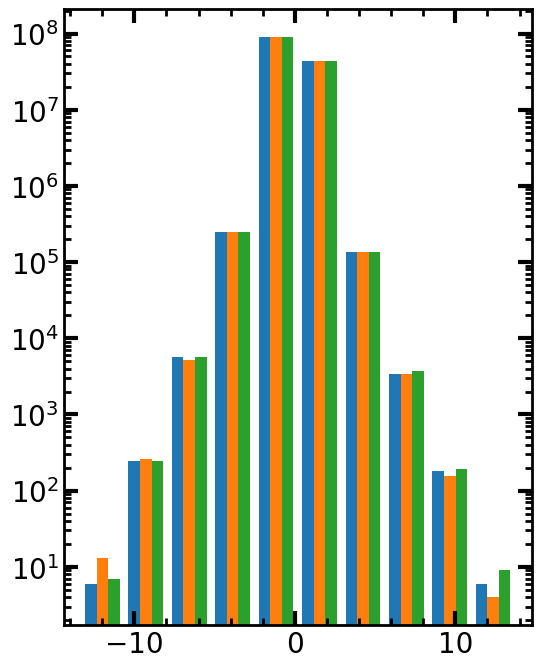

In [147]:
dx = (pos_HR_diluted-pos_LR)
dx[np.where(dx>sim_LR.header['BoxSize']/2.0)]  -= sim_LR.header['BoxSize']
dx[np.where(dx<-sim_LR.header['BoxSize']/2.0)] += sim_LR.header['BoxSize']
plt.hist(dx, log=True)

In [117]:
imax = np.argmax(dx[:,0])
print(dx[imax,0]) 
print(pos_HR_diluted[imax, :], pos_LR[imax, :])

13.708511
[266.946   976.99207 750.892  ] [253.2375 967.5103 749.5725]


(0.0, 100.0)

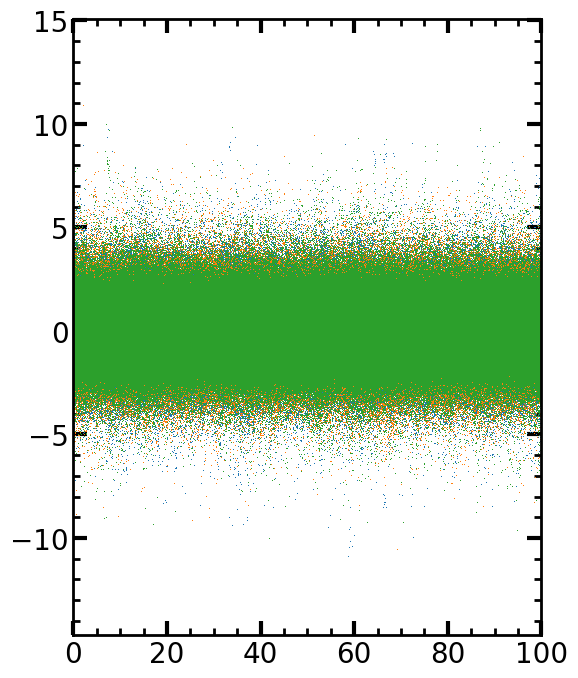

In [115]:
plt.plot(pos_HR_diluted[:,1], dx[:,0],',')
plt.plot(pos_HR_diluted[:,1], dx[:,1],',')
plt.plot(pos_HR_diluted[:,1], dx[:,2],',')
plt.xlim([0,100])

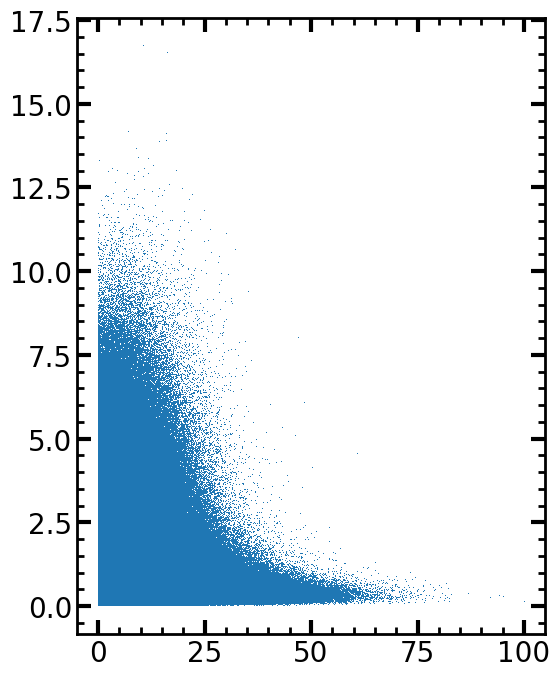

In [148]:
delta2= bmodel.linear_field.flatten()
delta2 -= np.mean(delta2)
plt.plot(delta2**2, np.sqrt(dx[:,0]**2+dx[:,1]**2+dx[:,2]**2),',')


(900.0, 1000.0)

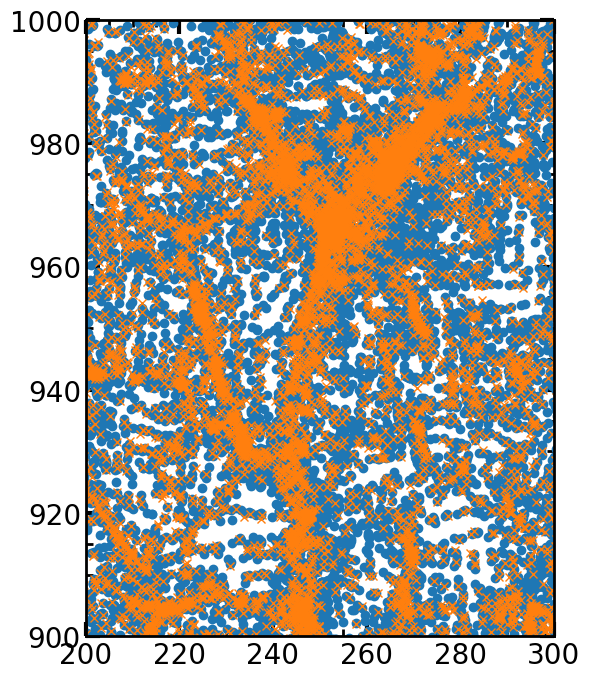

In [135]:
mask = (pos_HR_diluted[:,2] < 752) & (pos_HR_diluted[:,2] > 747) 
mask_LR = (pos_LR[:,2] < 755) & (pos_LR[:,2] > 745) 
plt.plot(pos_LR[mask_LR,0], pos_LR[mask_LR,1],'o')
plt.plot(pos_HR_diluted[mask,0], pos_HR_diluted[mask,1],'x')
plt.xlim([200,300]); plt.ylim([900,1000])
#plt.xlim([0,50]); plt.ylim([0,50])

In [218]:
_ngrid = 1024
bmodel_HR = bacco.BiasModel(sim=sim_HR, ngrid=_ngrid, sdm=False, mode="dm", mode_vel="combine",
                            npart_for_fake_sim=_ngrid, damping_scale=0.75, bias_model='expansion', mean_num_dens=None,
                            stochastic=False, deposit_method="cic", use_RSD=False, use_displacement_of_nn=False, interlacing=False,
                            indices=None, indices_vel=None, sdmhids=None)

_ngrid = 512
with open("quijote_{0}_neighfile.pickle".format("663"), 'rb') as f:
    lag_index = pickle.load(f)
bmodel_LR = bacco.BiasModel(sim=sim_LR, ngrid=_ngrid, sdm=False, mode="dm", mode_vel="combine",
                            npart_for_fake_sim=_ngrid, damping_scale=0.75, bias_model='expansion', mean_num_dens=None,
                            stochastic=False, deposit_method="cic", use_RSD=False, use_displacement_of_nn=False, interlacing=False,
                            indices=lag_index, indices_vel=None, sdmhids=None)

2024-08-16 15:50:56,351 bacco.BiasModel : Initialising Bias Model class ...
2024-08-16 15:51:10,428 bacco.BiasModel : Initialising Bias Model class ...


In [24]:
lt_k = np.logspace(np.log10(np.pi / 1000.), np.log10(2 * np.pi / 1000. * ngrid), num=100)

pk_lt = {'k':lt_k, 'pk':sim_HR.Cosmology.get_powerspec(lt_k), 'pk_nlin':sim_HR.Cosmology.get_powerspec(lt_k), 'pk_lt_log': False}
pk_delta_HR = bacco.statistics.compute_crossspectrum_twogrids(grid1=bmodel_HR.linear_field, pk_lt = pk_lt, 
                                                              box=sim_HR.header['BoxSize'], 
                                                              cosmology=sim_HR.Cosmology, 
                                                              grid2=bmodel_HR.linear_field, interlacing=False, 
                                                              ngrid=bmodel_HR.linear_field.shape[0],
                                                              normalise_grid1=False, normalise_grid2=False,
                                                              deconvolve_grid1=False,deconvolve_grid2=False, 
                                                              correct_grid=False,
                                                              kmin=0.01, kmax=1, nbins=50, log_binning=True)
pk_delta_LR = bacco.statistics.compute_crossspectrum_twogrids(grid1=bmodel_LR.linear_field, pk_lt = pk_lt, 
                                                              box=sim_LR.header['BoxSize'], 
                                                              cosmology=sim_HR.Cosmology, 
                                                              grid2=bmodel_LR.linear_field, interlacing=False, 
                                                              ngrid=bmodel_LR.linear_field.shape[0],
                                                              normalise_grid1=False, normalise_grid2=False,
                                                              deconvolve_grid1=False,deconvolve_grid2=False, 
                                                              correct_grid=False,
                                                              kmin=0.01, kmax=1, nbins=50, log_binning=True)

2024-08-16 12:29:04,087 bacco.statistics : Computing the power spectrum with ngrid=1024 and interlacing=False
2024-08-16 12:29:33,800 bacco.util : pk multipoles at k 0.010481130666019545 set to zero: it seems you have a lot of bins for this grid size
2024-08-16 12:29:33,802 bacco.util : pk multipoles at k 0.01151395323963562 set to zero: it seems you have a lot of bins for this grid size
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-08-16 12:29:33,807 bacco.util : pk multipoles at k 0.016768328203371985 set to zero: it seems you have 

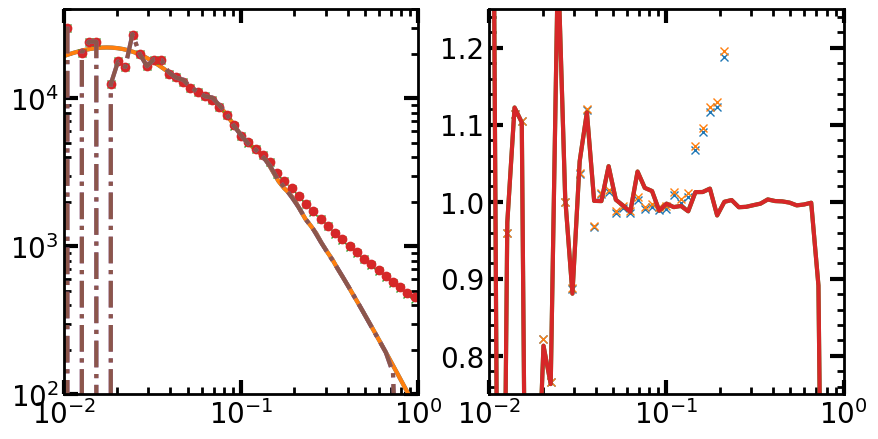

In [140]:
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True)

kk = np.logspace(-2,1,100)
ax[0].loglog(kk,sim_HR.Cosmology.get_powerspec_z(kk,1) ) ##1.28**2
ax[0].loglog(kk,sim_LR.Cosmology.get_powerspec_z(kk,1) )

ax[0].set_xlim([1e-2,1])
ax[0].set_ylim([1e2,4e4])
ax[1].set_ylim([0.75,1.25])

ax[0].loglog(pksim_LR['k'],pksim_LR['pk'],'x' ) 
ax[0].loglog(pksim_HR['k'],pksim_HR['pk'],'o' ) 

ax[0].loglog(pk_delta_HR['k'], pk_delta_HR['pk']/1024**6, label='$\delta_L(x)$', ls="-.")
ax[0].loglog(pk_delta_LR['k'], pk_delta_LR['pk']/512**6, label='$\delta_L(x)$', ls="-.")

ax[1].semilogx(pksim_LR['k'],pksim_LR['pk']/sim_HR.Cosmology.get_powerspec_z(pksim_LR['k'],1),'x' ) 
ax[1].semilogx(pksim_HR['k'],pksim_HR['pk']/sim_HR.Cosmology.get_powerspec_z(pksim_HR['k'],1),'x' ) 

ax[1].semilogx(pksim_LR['k'],pk_delta_HR['pk']/1024**6/sim_HR.Cosmology.get_powerspec_z(pksim_LR['k'],1) ) 
ax[1].semilogx(pksim_HR['k'],pk_delta_LR['pk']/512**6/sim_HR.Cosmology.get_powerspec_z(pksim_HR['k'],1)) 


## Loading sim

In [36]:

qsim, ngrid, ic_type = "663_HR", 1024, "gadget_hdf5"
qsim, ngrid, ic_type = "663", 512, "gadget2"

sim_ICs = bacco.Simulation(basedir="/dipc/reangulo/tmp/{0}/ICs/".format(qsim), ngenic_phases=True, phase_type=1,
                       dm_file="ics", sim_format=ic_type, phase=0.00, fixedPk=False, UnitLength_in_cm=3.085678e+21,
                       ns=0.960700, sigma8=0.831100, seed=663, hubble=0.701500, omega_baryon=0.046250, tau=0.0952, timebegin=0.0078125)

sim = bacco.Simulation(basedir="/dipc/reangulo/tmp/{0}/".format(qsim), ngenic_phases=True, phase_type=1,
                       dm_file="snapdir_004/snap_004", sim_format="gadget_hdf5", phase=0.00, fixedPk=False, UnitLength_in_cm=3.085678e+21,
                       ns=0.960700, sigma8=0.831100, seed=663, hubble=0.701500, omega_baryon=0.046250, tau=0.0952, timebegin=0.0078125)
#sim.dm['pos'] = sim.dm['pos']/1000
index_neigh = sim.dm['ids']-1
pksim = sim.get_Power(kmin=0.01, kmax=1, nbins=50, log_binning=True, deposit_method='cic')


2024-08-16 12:36:06,856 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 12:36:06,857 bacco.sims : Initialising simulation Default
2024-08-16 12:36:06,910 bacco.sims : Some parameters could not be set because of Gadget type-1 snapshot. Using defaults.
2024-08-16 12:36:06,911 bacco.cosmo :    initialization took 0.000 secs
2024-08-16 12:36:06,911 bacco.sims : ...done in 0.0555 s
2024-08-16 12:36:06,912 bacco.sims : Initial conditions compatible with Gadget-3 Ngenic
2024-08-16 12:36:06,912 bacco.sims : Initialising simulation Default
2024-08-16 12:36:06,912 bacco.sims : try /dipc/reangulo/tmp/663/snapdir_004/snap_004
2024-08-16 12:36:06,914 bacco.sims : Loading /dipc/reangulo/tmp/663/snapdir_004/snap_004
2024-08-16 12:36:06,918 bacco.cosmo :    initialization took 0.000 secs
2024-08-16 12:36:06,923 bacco.sims : ...done in 0.00706 s
2024-08-16 12:36:06,929 bacco.sims : Read data for 16934774/134217728 particles...


/dipc/reangulo/tmp/663/snapdir_004/snap_004.0.hdf5


2024-08-16 12:36:07,446 bacco.sims : Read data for 16934774/134217728 particles...
2024-08-16 12:36:07,449 bacco.sims : Read data for 16755040/134217728 particles...
2024-08-16 12:36:07,968 bacco.sims : Read data for 16755040/134217728 particles...
2024-08-16 12:36:07,973 bacco.sims : Read data for 16786319/134217728 particles...
2024-08-16 12:36:08,487 bacco.sims : Read data for 16786319/134217728 particles...
2024-08-16 12:36:08,491 bacco.sims : Read data for 16710594/134217728 particles...
2024-08-16 12:36:08,996 bacco.sims : Read data for 16710594/134217728 particles...
2024-08-16 12:36:09,001 bacco.sims : Read data for 16725881/134217728 particles...
2024-08-16 12:36:09,466 bacco.sims : Read data for 16725881/134217728 particles...
2024-08-16 12:36:09,469 bacco.sims : Read data for 16779409/134217728 particles...
2024-08-16 12:36:09,939 bacco.sims : Read data for 16779409/134217728 particles...
2024-08-16 12:36:09,943 bacco.sims : Read data for 16775898/134217728 particles...
2024

bacco.cosmo :    begin reps RK computation
bacco.cosmo :    end of RK computation. It took 0 s.
bacco.mesh : boxsize=1000.000000 ngrid=256, nthreads=8, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 134217728 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1000.000000; ngrid 256; nthreads 8; interlacing 1; deposit_method 1; log_binning 1; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1.34218e+08 (grid1) 1.34218e+08 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062621 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.143968 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000398 secs
bacco.power : Deallocating arrays
bacco.cosmo :    begin reps RK computation
bacco.cosmo :    end of RK computation. I

2024-08-16 12:36:16,506 bacco.statistics :  done compute.power
2024-08-16 12:36:16,508 bacco.util : pk multipoles at k 0.010481130666019545 set to zero: it seems you have a lot of bins for this grid size
2024-08-16 12:36:16,510 bacco.util : pk multipoles at k 0.01151395323963562 set to zero: it seems you have a lot of bins for this grid size
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1931: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1931: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1931: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-08-16 12:36:16,514 bacco.util : pk multipoles at k 0.016768328203371985 set to zero: it seems you have a lot of bins for this grid size
/scratch/reang

(512, 512, 512, 3)

In [130]:
q = bacco.visualization.uniform_grid(npix=ngrid, L=1000, ndim=3, bounds=False)
disp = np.load("/cosmos_storage/home/mpelle/Yin_data/Quijote/LH0663/dis_0663.npy")
displ = np.zeros_like(q)
displ[:,:,:,0] = disp[0]
displ[:,:,:,1] = disp[1]
displ[:,:,:,2] = disp[2]

pp = (q + displ + 1000) % 1000
pp = pp.reshape(512**3,3)


ValueError: could not broadcast input array from shape (512,512,512) into shape (1024,1024,1024)

## Validating the stored displacement fields

In [123]:
snapnum = 4
ptype   = [1] 
BoxSize = 1000
root    = "/dipc/reangulo/tmp/"
ICs_snapshot = '%s/%s/ICs/ics'%(root,qsim)
snapshot     = '%s/%s/snapdir_%03d/snap_%03d'%(root,qsim,snapnum,snapnum)

# read the positions and IDs of the ICs
pos_ICs = read_block(ICs_snapshot, "POS ", ptype)/1e3 #Mpc/h
IDs_ICs = read_block(ICs_snapshot, "ID  ", ptype)-1   #IDs begin from 0

# sort the ICs particles by IDs
indexes = np.argsort(IDs_ICs)
pos_ICs = pos_ICs[indexes]; 
#del IDs_ICs

# read the positions and IDs of the z=0 snapshot
pos = read_block(snapshot, "POS ", ptype)/1e3 #Mpc/h
IDs = read_block(snapshot, "ID  ", ptype)-1   #Make IDs begin from 0


#del IDs


In [ ]:
sim.header

In [124]:
# find the grid coordinates of the particles
grid_index = (np.round((pos_ICs/BoxSize)*ngrid, decimals=0)).astype(np.int32)
grid_index[np.where(grid_index==ngrid)]=0
pos_lag    = grid_index*BoxSize/ngrid #get the lagrangian coordinates
grid_index = grid_index[:,0]*ngrid**2 + grid_index[:,1]*ngrid + grid_index[:,2]
indexes2   = np.argsort(grid_index)
# sort the particles by IDs
indexes = np.argsort(IDs)
lag_index = indexes[indexes2]

indexes = np.argsort(IDs_ICs)
lag_index_ics = indexes[indexes2]

# safety check
grid_index = grid_index[indexes2]
diff = grid_index[1:] - grid_index[:-1]
if np.any(diff!=1):  raise Exception('positions not properly sorted')

#Saving indexes 

with open("quijote_{0}_neighfile.pickle".format(qsim), 'wb') as f:
    pickle.dump(lag_index, f, protocol=-1)
    
with open("quijote_ics_{0}_neighfile.pickle".format(qsim), 'wb') as f:
    pickle.dump(lag_index_ics, f, protocol=-1)
    
# More checks
pos     = pos[indexes];  
pos_lag = pos_ICs[indexes2];  

# compute displacement field
qdisp = pos - pos_ICs;  

# take into account periodic boundary conditions


qdisp = qdisp[indexes2]


dx = sim.dm['pos'][lag_index]-pp
dx[np.where(dx>BoxSize/2.0)]  -= BoxSize
dx[np.where(dx<-BoxSize/2.0)] += BoxSize

print("Maximum difference between Eulerian positions: {0} {0}".format(np.min(dx), np.max(dx)))


ValueError: operands could not be broadcast together with shapes (1073741824,3) (134217728,3) 

## Need to figure out why this doesn't work

In [49]:
IDs_ICs = read_block(ICs_snapshot, "ID  ", ptype)-1   #IDs begin from 0

In [68]:
_qq.shape

(64, 64, 64, 3)

In [103]:
_qq = bacco.visualization.uniform_grid(npix=64, L=125, ndim=3, bounds=False)
subbox = 125.
qx = _qq[...,0].flatten() 
qy = _qq[...,1].flatten() 
qz = _qq[...,2].flatten() 
_ids = np.arange(64**3)

qq = []
ii = 0
glassfactor = 8
for i in range(glassfactor):
    for j in range(glassfactor):
        for k in range(glassfactor):
            _qqx = np.array([qx + i*subbox, qy + j*subbox, qz + k*subbox])
            if ii == 0:
                qq = _qqx
                ids = _ids
            else:
                qq = np.hstack((qq,_qqx))
                ids = np.hstack((ids,_ids+ii*64**3))
            print(np.shape(qq))
            ii+=1


(3, 262144)
(3, 524288)
(3, 786432)
(3, 1048576)
(3, 1310720)
(3, 1572864)
(3, 1835008)
(3, 2097152)
(3, 2359296)
(3, 2621440)
(3, 2883584)
(3, 3145728)
(3, 3407872)
(3, 3670016)
(3, 3932160)
(3, 4194304)
(3, 4456448)
(3, 4718592)
(3, 4980736)
(3, 5242880)
(3, 5505024)
(3, 5767168)
(3, 6029312)
(3, 6291456)
(3, 6553600)
(3, 6815744)
(3, 7077888)
(3, 7340032)
(3, 7602176)
(3, 7864320)
(3, 8126464)
(3, 8388608)
(3, 8650752)
(3, 8912896)
(3, 9175040)
(3, 9437184)
(3, 9699328)
(3, 9961472)
(3, 10223616)
(3, 10485760)
(3, 10747904)
(3, 11010048)
(3, 11272192)
(3, 11534336)
(3, 11796480)
(3, 12058624)
(3, 12320768)
(3, 12582912)
(3, 12845056)
(3, 13107200)
(3, 13369344)
(3, 13631488)
(3, 13893632)
(3, 14155776)
(3, 14417920)
(3, 14680064)
(3, 14942208)
(3, 15204352)
(3, 15466496)
(3, 15728640)
(3, 15990784)
(3, 16252928)
(3, 16515072)
(3, 16777216)
(3, 17039360)
(3, 17301504)
(3, 17563648)
(3, 17825792)
(3, 18087936)
(3, 18350080)
(3, 18612224)
(3, 18874368)
(3, 19136512)
(3, 19398656)
(3, 1

In [141]:
# find the grid coordinates of the particles
grid_index = (np.round((qq.T/BoxSize)*grid, decimals=0)).astype(np.int32)
grid_index[np.where(grid_index==grid)]=0
grid_index = grid_index[:,0]*grid**2 + grid_index[:,1]*grid + grid_index[:,2]
indexes2   = np.argsort(grid_index)

# sort the particles by IDs
indexes = np.argsort(sim.dm['ids'])
lag_index2 = indexes[indexes2]


In [153]:
dx = qq[:,indexes2]-pos_lag.T
dx[np.where(dx>BoxSize/2.0)]  -= BoxSize
dx[np.where(dx<-BoxSize/2.0)] += BoxSize

(array([1.5790000e+03, 9.2011000e+04, 2.0360500e+06, 1.6201001e+07,
        4.5979010e+07, 4.8558392e+07, 1.8643403e+07, 2.5717000e+06,
        1.3336200e+05, 1.2200000e+03]),
 array([-0.29376221, -0.23556519, -0.17736816, -0.11917114, -0.06097412,
        -0.0027771 ,  0.05541992,  0.11361694,  0.17181396,  0.23001099,
         0.28820801]),
 <BarContainer object of 10 artists>)

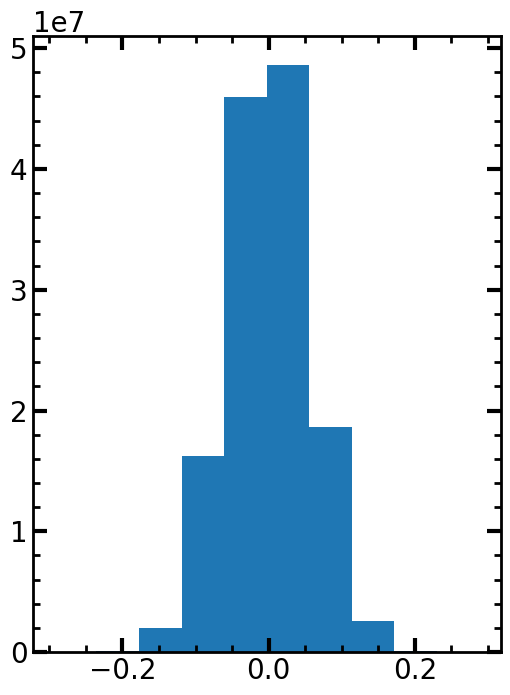

In [161]:
plt.hist(dx[2,:])

In [162]:
qq

array([[  0.      ,   0.      ,   0.      , ..., 998.0469  , 998.0469  ,
        998.0469  ],
       [  0.      ,   0.      ,   0.      , ..., 998.0469  , 998.0469  ,
        998.0469  ],
       [  0.      ,   1.953125,   3.90625 , ..., 994.1406  , 996.09375 ,
        998.0469  ]], dtype=float32)

In [158]:
dx.shape

(3, 134217728)

In [144]:
print(np.max(np.abs(lag_index2-lag_index)))
i0,i1=4050,4150
print(lag_index[i0:i1])
print(lag_index2[i0:i1])

0
[1835474 1835475 1835476 1835477 1835478 1835479 1835480 1835481 1835482
 1835483 1835484 1835485 1835486 1835487 1835488 1835489 1835490 1835491
 1835492 1835493 1835494 1835495 1835496 1835497 1835498 1835499 1835500
 1835501 1835502 1835503 1835504 1835505 1835506 1835507 1835508 1835509
 1835510 1835511 1835512 1835513 1835514 1835515 1835516 1835517 1835518
 1835519     512     513     514     515     516     517     518     519
     520     521     522     523     524     525     526     527     528
     529     530     531     532     533     534     535     536     537
     538     539     540     541     542     543     544     545     546
     547     548     549     550     551     552     553     554     555
     556     557     558     559     560     561     562     563     564
     565]
[1835474 1835475 1835476 1835477 1835478 1835479 1835480 1835481 1835482
 1835483 1835484 1835485 1835486 1835487 1835488 1835489 1835490 1835491
 1835492 1835493 1835494 1835495 183549

In [129]:
IDs-sim.dm['ids']

array([-1, -1, -1, ..., -1, -1, -1])

array([400, 401, 402, 403, 404, 405, 406, 407, 408, 409])

In [134]:
lag_index[400:410]

array([1572880, 1572881, 1572882, 1572883, 1572884, 1572885, 1572886,
       1572887, 1572888, 1572889])

In [118]:
print(np.min(lag_index2-lag_index))

0


In [53]:
print(IDs_ICs[4050:4150])
print(grid_index[4050:4150])

[  4050   4051   4052   4053   4054   4055   4056   4057   4058   4059
   4060   4061   4062   4063   4064   4065   4066   4067   4068   4069
   4070   4071   4072   4073   4074   4075   4076   4077   4078   4079
   4080   4081   4082   4083   4084   4085   4086   4087   4088   4089
   4090   4091   4092   4093   4094   4095 262144 262145 262146 262147
 262148 262149 262150 262151 262152 262153 262154 262155 262156 262157
 262158 262159 262160 262161 262162 262163 262164 262165 262166 262167
 262168 262169 262170 262171 262172 262173 262174 262175 262176 262177
 262178 262179 262180 262181 262182 262183 262184 262185 262186 262187
 262188 262189 262190 262191 262192 262193 262194 262195 262196 262197]
[4050 4051 4052 4053 4054 4055 4056 4057 4058 4059 4060 4061 4062 4063
 4064 4065 4066 4067 4068 4069 4070 4071 4072 4073 4074 4075 4076 4077
 4078 4079 4080 4081 4082 4083 4084 4085 4086 4087 4088 4089 4090 4091
 4092 4093 4094 4095 4096 4097 4098 4099 4100 4101 4102 4103 4104 4105
 4106

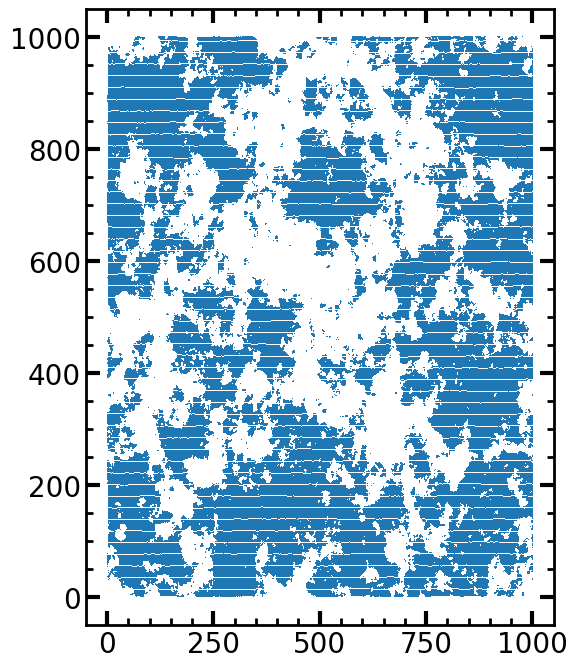

In [56]:
mask = pos_ICs[:,2] < 1
plt.plot(pos_ICs[mask,0], pos_ICs[mask,1],',')

In [51]:
neq = np.where( (grid_index[:10000]-IDs_ICs[:10000]) == 0)[0]
print("number of equals: {0} of {1}".format(len(neq), 512**3))

number of equals: 4096 of 134217728


In [ ]:
ngrid = 600
ids = sim.dm['ids'] - 1
qq = np.zeros(ids.shape + (3,), dtype=np.float32)

qq[..., 0] = ids // ngrid**2
qq[..., 1] = (ids // ngrid) % ngrid
qq[..., 2] = ids % ngrid
qq = qq * (sim.header['BoxSize']/ngrid)

In [70]:
qdisp

array([[-3.0374146 ,  1.5611234 , -3.1153564 ],
       [-3.194336  ,  1.5179172 , -5.0926514 ],
       [-2.3466797 ,  1.0554459 , -7.0186768 ],
       ...,
       [ 0.03173828, -0.29437256, -3.7548218 ],
       [-0.3324585 , -0.67767334, -6.192688  ],
       [-0.65753174,  1.6317139 , -4.8081055 ]], dtype=float32)

In [71]:
disp[0,...]

array([[[-3.0755615 , -3.2235107 , -2.3686523 , ..., -1.9675903 ,
         -2.4111328 , -2.6365967 ],
        [-2.9282227 , -3.2504883 , -3.1639404 , ..., -3.8048706 ,
         -3.5530396 , -3.8181152 ],
        [-4.1376343 , -4.182312  , -3.2202148 , ..., -5.6550903 ,
         -5.579956  , -4.920471  ],
        ...,
        [-1.9995117 , -2.192627  , -1.8391113 , ..., -2.0495605 ,
         -2.284668  , -2.1079102 ],
        [-1.2908325 , -1.541626  , -1.944397  , ..., -2.0964355 ,
         -2.157959  , -2.048767  ],
        [-2.1992188 , -2.0715942 , -2.1852417 , ..., -1.961731  ,
         -2.3862915 , -1.5228882 ]],

       [[-4.6290283 , -4.572571  , -4.6013184 , ..., -3.824707  ,
         -4.236328  , -3.3980713 ],
        [-3.0847168 , -2.9988403 , -2.9579468 , ..., -4.1660156 ,
         -3.6616821 , -3.3239136 ],
        [-3.376587  , -2.9763184 , -3.4088745 , ..., -4.2197876 ,
         -3.4332886 , -2.8952637 ],
        ...,
        [-3.9508057 , -3.9735718 , -3.8983765 , ..., -

In [315]:
# compute displacement field
zdisp = pos_ICs - pos_lag;  del pos_ICs

# take into account periodic boundary conditions
zdisp[np.where(zdisp>BoxSize/2.0)]  -= BoxSize
zdisp[np.where(zdisp<-BoxSize/2.0)] += BoxSize
zdisp = zdisp
zdisp = zdisp[indexes2]


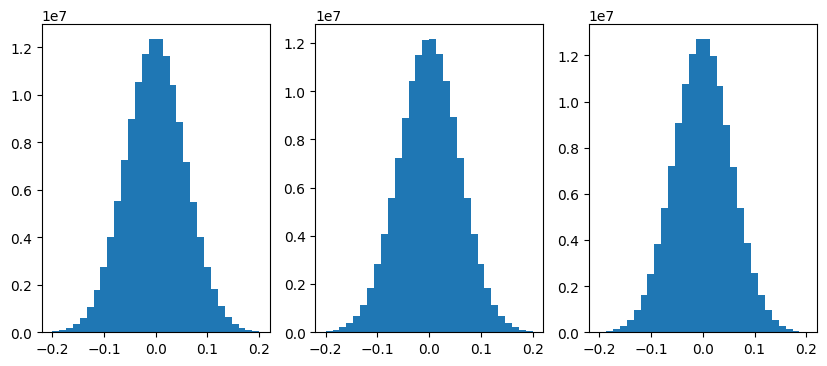

In [319]:
#plt.hist(dx, range=[-100,100],bins=30)
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(zdisp[:,axis].flatten(),ls=':',range=[-0.2,0.2], bins=30)
    #ax[axis].hist(disp[axis,...].flatten(),ls=':',range=[-20,20], bins=30)

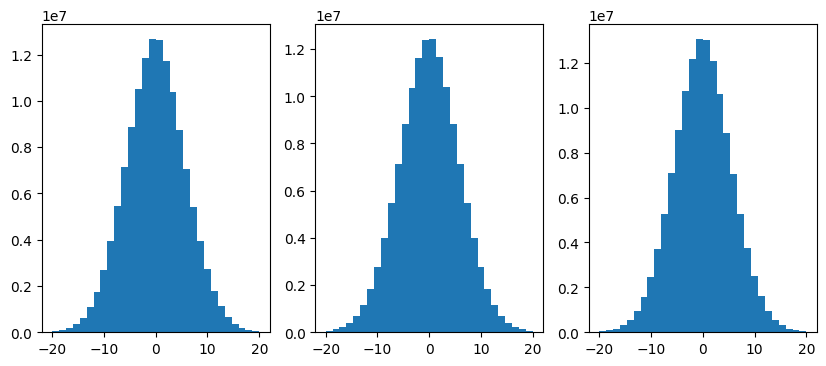

In [310]:
#plt.hist(dx, range=[-100,100],bins=30)
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(qdisp[:,axis].flatten(),ls=':',range=[-20,20], bins=30)
    #ax[axis].hist(disp[axis,...].flatten(),ls=':',range=[-20,20], bins=30)

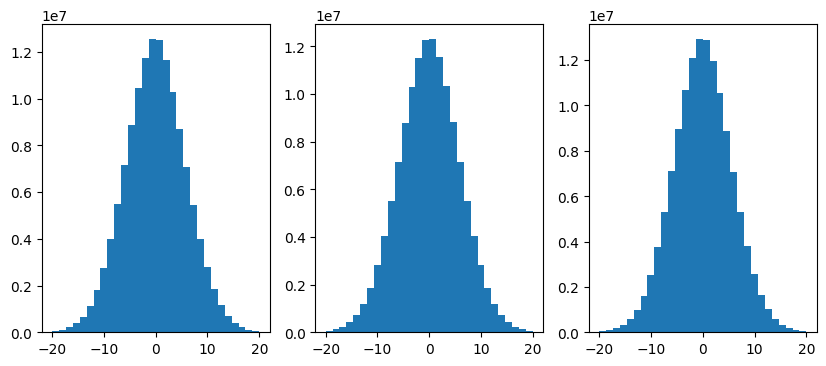

In [307]:
fig, ax = plt.subplots(1,3, figsize=(10,4))
for axis in range(3):
    ax[axis].hist(disp[axis,...].flatten(),ls=':',range=[-20,20], bins=30)

In [9]:
print("min", np.min(index_neigh-sim.dm['ids']+1))
print("max", np.max(index_neigh-sim.dm['ids']+1))

min 0
max 0


(array([13424096., 13412008., 13427713., 13424676., 13419931., 13424348.,
        13415202., 13425804., 13421734., 13422216.]),
 array([-4.99999878e+02, -3.99999878e+02, -2.99999908e+02, -1.99999908e+02,
        -9.99999237e+01,  6.10351562e-05,  1.00000046e+02,  2.00000031e+02,
         3.00000031e+02,  4.00000000e+02,  5.00000000e+02]),
 <BarContainer object of 10 artists>)

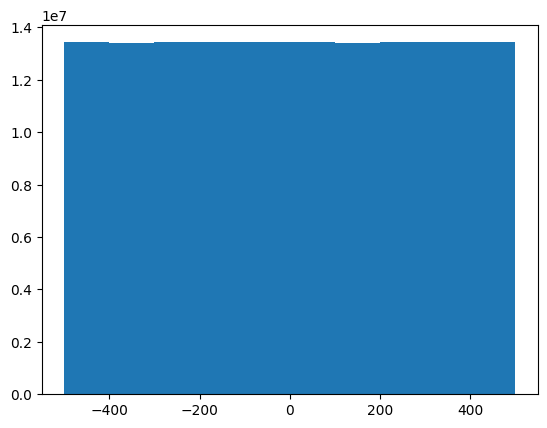

In [93]:
dx = (sim.dm['pos'][:,0]-q[...,0].flatten()[index_neigh] + 2000) % 1000 
dy = (sim.dm['pos'][:,1]-q[...,2].flatten() + 2000) % 1000 
dz = (sim.dm['pos'][:,2]-q[...,2].flatten()[index_neigh] + 2000) % 1000 

dx[dx > 500] -= 1000
dy[dy > 500] -= 1000
dz[dz > 500] -= 1000

#plt.hist(dx)
plt.hist(dy)
#plt.hist(dz)

## validating delta

In [3]:
#Loading qq indices
with open("quijote_ics_{0}_neighfile.pickle".format(qsim), 'rb') as f:
    lag_index_ics = pickle.load(f)
pp_ics = sim_ICs.dm['pos'][lag_index_ics]

2024-08-15 19:58:14,334 bacco.sims : Allocating memory for 134217728 particles 1536.0Mb
2024-08-15 19:58:14,348 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,371 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,383 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,394 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,404 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,414 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,424 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,435 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,444 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,454 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,463 bacco.sims : Read data for 262144/134217728 particles...
2024-08-15 19:58:14,4

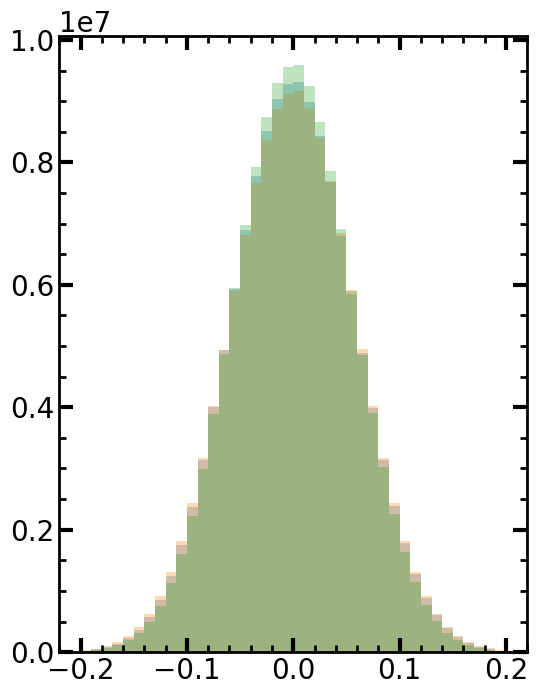

In [4]:
#let's compute the ZA displacement field
q = bacco.visualization.uniform_grid(npix=ngrid, L=sim.header['BoxSize'], ndim=3, bounds=False)

disp_za = pp_ics - q.reshape(ngrid**3,3)
disp_za[np.where(disp_za>sim.header['BoxSize']/2.0)]  -= sim.header['BoxSize']
disp_za[np.where(disp_za<-sim.header['BoxSize']/2.0)] += sim.header['BoxSize']

for i in range(3):
    plt.hist(disp_za[:,i],bins=40, range=[-0.2,0.2], alpha=0.3)

In [5]:
sdisp =      sim_ICs.compute_disp_field(ngrid=ngrid, LPT_order=1, damping_scale=1e4).reshape(3,ngrid**3).T
sdisp_2lpt = sim_ICs.compute_disp_field(ngrid=ngrid, LPT_order=2, damping_scale=1e4).reshape(3,ngrid**3).T

2024-08-15 19:58:34,840 bacco.cosmo :    computed CLASS power spectrum at z=0.00 in 0.761 secs
2024-08-15 19:58:34,842 bacco.cosmo :    created Pk(z=0) tab from k 0.0007014999999999996 to 100000.0 h/Mpc
2024-08-15 19:58:34,844 bacco.cosmo :    computed boundary conditions for reps using CLASS in 0.00142 secs
2024-08-15 19:58:34,957 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-15 19:58:34,958 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-15 19:58:34,965 bacco.cosmo : Warning! 3LPT growth factor (3a) with reps not yet implemented
2024-08-15 19:58:34,966 bacco.cosmo :   Warning! 3LPT growth factor (3b) with reps not yet implemented
2024-08-15 19:58:34,967 bacco.sims : Generating displacement field: Di=1.0
2024-08-15 19:58:41,371 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-15 19:58:41,373 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-15 19:58:41,379 bac

In [6]:
im1 = sdisp.reshape(ngrid,ngrid,ngrid,3)
im2 = disp_za.reshape(ngrid,ngrid,ngrid,3)
im1_2lpt = sdisp_2lpt.reshape(ngrid,ngrid,ngrid,3)


In [7]:
import random
rdm = random.sample(list(np.arange(0,ngrid**3)), 10000)

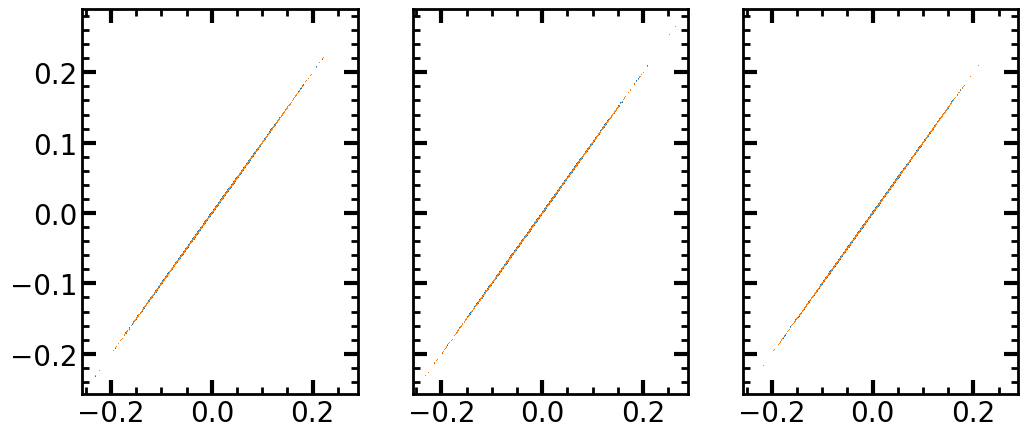

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,5), sharex=True, sharey=True)
for i in range(3):
 #   ax[i].plot([-0.3,0.3],[-0.3,0.3])
    ax[i].plot(im1[...,i].flatten()[rdm], im2[...,i].flatten()[rdm],',')
    ax[i].plot(im1[...,i].flatten()[rdm], im1_2lpt[...,i].flatten()[rdm],',')

In [10]:
for axis in np.arange(3):
    print("Stdev between BACCO and QUIJOTE's ICs:",np.std(im1[...,axis]-im2[...,axis]))


Stdev between BACCO and QUIJOTE's ICs: 0.016026508
Stdev between BACCO and QUIJOTE's ICs: 0.016278163
Stdev between BACCO and QUIJOTE's ICs: 0.015537909


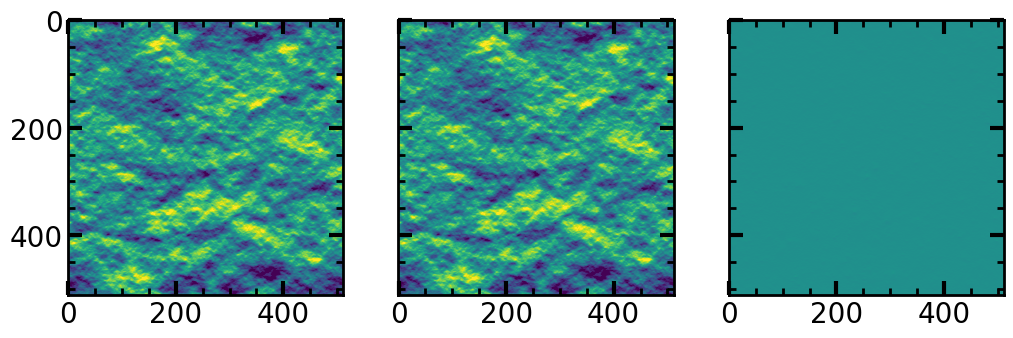

In [9]:
col, axis = 11, 0
fig, ax = plt.subplots(1,3, figsize=(12,5), sharex=True, sharey=True)
ax[0].imshow(im1[:,:,col,axis], vmin=-0.15,vmax=0.15)
ax[1].imshow(im2[:,:,col,axis], vmin=-0.15,vmax=0.15)
ax[2].imshow(im2[:,:,col,axis]-im1[:,:,col,axis], vmin=-0.015,vmax=0.015)

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 4.0000000e+00, 1.2860000e+03,
        8.4393000e+04, 2.0856290e+06, 1.7704478e+07, 5.0023686e+07,
        4.7497667e+07, 1.5152027e+07, 1.6089520e+06, 5.8843000e+04,
        7.6100000e+02, 2.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]),
 array([-0.01  , -0.0095, -0.009 , -0.0085, -0.008 , -0.0075, -0.007 ,
        -0.0065, -0.006 , -0.0055, -0.005 , -0.0045, -0.004 , -0.0035,
        -0.003 , -0.0025, -0.002 , -0.0015, -0.001 , -0.0005,  0.    ,
         0.0005,  0.001 ,  0.0015,  0.002 ,  0.0025,  0.003 ,  0.0035,
         0.004 ,  0.0045,  0.005 ,

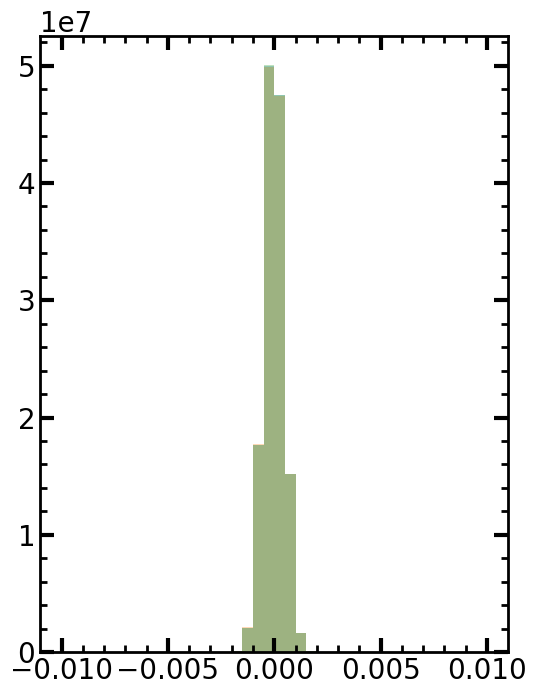

In [10]:
#plt.hist(sdisp_2lpt[:,0]-sdisp[:,0])
plt.hist(sdisp[:,0]-disp_za[:,0],bins=40, range=[-0.01,0.01], alpha=0.3)
plt.hist(sdisp[:,1]-disp_za[:,1],bins=40, range=[-0.01,0.01], alpha=0.3)
plt.hist(sdisp[:,2]-disp_za[:,2],bins=40, range=[-0.01,0.01], alpha=0.3)

# Creating Bias model

In [37]:
#Loading if necessary
with open("quijote_{0}_neighfile.pickle".format(qsim), 'rb') as f:
    lag_index = pickle.load(f)

In [38]:
# Downsampling
dilution = False
if dilution is True:
    ndilution = 4
    pos = sim.dm['pos'][lag_index,:].reshape(ngrid,ngrid, ngrid,3)

    _lag_index = lag_index.reshape(ngrid,ngrid, ngrid)
    _lag_index = _lag_index[::ndilution,::ndilution,::ndilution]
    spos = pos[::ndilution,::ndilution,::ndilution,:]
    
    _ngrid = ngrid//ndilution
    sim.dm['pos'] = spos.reshape(_ngrid**3, 3)
    qids = np.arange(_ngrid**3)
else:
    qids = lag_index
    _ngrid = ngrid

In [167]:
## Assigning diluted HR positions
#sim.dm['pos'] = pos_LR
sim.dm['pos'] = pos_HR_diluted
qids = qids_HR_diluted

In [160]:
# Using LPT positions
q = bacco.visualization.uniform_grid(npix=_ngrid, L=sim.header['BoxSize'], ndim=3, bounds=False).reshape(ngrid**3,3)
sim.dm['pos'] = q + sim.compute_disp_field(ngrid=_ngrid, LPT_order=1, damping_scale=1e4).reshape(3,_ngrid**3).T
qids = np.arange(_ngrid**3)


2024-08-16 14:53:21,531 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-16 14:53:21,538 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-16 14:53:21,544 bacco.cosmo : Warning! 3LPT growth factor (3a) with reps not yet implemented
2024-08-16 14:53:21,545 bacco.cosmo :   Warning! 3LPT growth factor (3b) with reps not yet implemented
2024-08-16 14:53:21,546 bacco.sims : Generating displacement field: Di=1.0


In [159]:
q.shape

(512, 512, 512, 3)

In [168]:

bmodel = bacco.BiasModel(sim=sim, ngrid=_ngrid, sdm=False, mode="dm", mode_vel="combine",
                            npart_for_fake_sim=_ngrid, damping_scale=0.75, bias_model='expansion', mean_num_dens=None,
                            stochastic=False, deposit_method="cic", use_RSD=False, use_displacement_of_nn=False, interlacing=False,
                            indices=qids, indices_vel=None, sdmhids=None)
#fields = bmodel.get_eul_field_terms()


2024-08-16 15:04:23,441 bacco.BiasModel : Initialising Bias Model class ...


In [162]:
pk = bmodel.compute_power_terms(kmin=0.01, kmax=1, nbins=50, log_binning=True, correct_grid=False)

2024-08-16 14:53:31,102 bacco.BiasModel : Computing power spectra of bias terms ...
2024-08-16 14:53:31,104 bacco.BiasModel : Memory used: 119.877865472 Gigabytes
2024-08-16 14:53:31,105 bacco.BiasModel : Computing bias model power spectra...
2024-08-16 14:53:31,105 bacco.BiasModel : 0.9999999999999998
2024-08-16 14:53:31,106 bacco.BiasModel : 
    -----------------------------------------------
            Default cosmology
            LCDM model 
            ------------------------------------
            Ω cold dark matter = 0.27604999999999996
            Ω baryon = 0.04625
            Ω cold matter = 0.3223
            Ω matter = 0.3223
            Ω dark energy = 0.6777
            Ω neutrino  = 0.0 
            Ω radiation = 0.0
            Ω curvature = 0.0
            Ω total = 1.0
            Σ neutrino mass = 0.0 eV
            Hubble =  70.15 Km/s/Mpc
            ns = 0.9607
            As = 1.821891093442339e-09
            σ8 (cold matter) = 0.8311
            σ8 (matter

nvolve_grid2=0
bacco.power : total mass -0.0109258 (grid1) -0.0109258 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.453107 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.351636 sec
bacco.power : Starting Fourier loop 
bacco.power : Doing inverse FFT
bacco.power : Creating final array
bacco.power : done Fourier loop in 0.537726 secs
bacco.power : Deallocating arrays
 bacco.lss_scaler : 488 P(k) values; Di = (1.000000, 1.000000, -0.112956, 0.121094); nthreads =8; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
 bacco.lss_scaler : 488 P(k) values; Di = (1.000000, 1.000000, 1.000000, 1.000000); nthreads =8; seed =663 
bacco.lss_scaler: start computing linear field...
bacco.lss_scaler: seed =663 ngrid=512 pkfixed=0 phase=0.000000, phase_type=1; precision=single 
bacco.lss: computing seed table
bacco.mesh : boxsize=10

2024-08-16 14:54:42,887 bacco.statistics :  ...done in 2.6 s
2024-08-16 14:54:43,433 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:54:46,205 bacco.statistics :  ...done in 2.77 s
2024-08-16 14:54:46,744 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:54:49,558 bacco.statistics :  ...done in 2.81 s
2024-08-16 14:54:50,105 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:54:52,747 bacco.statistics :  ...done in 2.64 s
2024-08-16 14:54:53,293 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:54:56,009 bacco.statistics :  ...done in 2.72 s
2024-08-16 14:54:56,551 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:54:59,180 bacco.statistics :  ...done in 2.63 s
2024-08-16 14:54:59,628 bacco.statistics : Computing the power spectrum with ngrid=5

took 0.448480 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.366220 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000172 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 1 (grid1) -1.88078e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.629036 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.371455 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000181 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_

2024-08-16 14:55:05,387 bacco.statistics :  ...done in 2.67 s
2024-08-16 14:55:05,825 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:55:08,434 bacco.statistics :  ...done in 2.61 s
2024-08-16 14:55:08,986 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:55:11,842 bacco.statistics :  ...done in 2.86 s
2024-08-16 14:55:12,384 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:55:15,057 bacco.statistics :  ...done in 2.67 s
2024-08-16 14:55:15,506 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False
2024-08-16 14:55:18,138 bacco.statistics :  ...done in 2.63 s
2024-08-16 14:55:18,217 bacco.BiasModel : Done computing power spectra terms.


In [21]:
print(np.mean(bmodel.linear_field),np.std(bmodel.linear_field) )

2.3404311e-08 1.6970181


In [156]:
lt_k = np.logspace(np.log10(np.pi / sim.header['BoxSize']), np.log10(2 * np.pi / sim.header['BoxSize'] * ngrid), num=100)

pk_lt = {'k':lt_k, 'pk':sim.Cosmology.get_powerspec(lt_k), 'pk_nlin':sim.Cosmology.get_powerspec(lt_k), 'pk_lt_log': False}
pk_delta = bacco.statistics.compute_crossspectrum_twogrids(grid1=bmodel.linear_field, pk_lt = pk_lt, box=sim.header['BoxSize'], cosmology=sim.Cosmology, 
                                                           grid2=bmodel.linear_field, interlacing=False, ngrid=bmodel.linear_field.shape[0],
                                                           normalise_grid1=False, normalise_grid2=False,
                                                           deconvolve_grid1=False,deconvolve_grid2=False, correct_grid=False,
                                                          kmin=0.01, kmax=1, nbins=50, log_binning=True)

2024-08-16 14:52:20,042 bacco.statistics : Computing the power spectrum with ngrid=512 and interlacing=False


nvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -7.65595e-11 (grid1) -6.30875e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.701329 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.388742 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000191 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -4.85505e-07 (grid1) -4.85505e-07 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.572115 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.410456 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000174 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8;

2024-08-16 14:52:23,417 bacco.util : pk multipoles at k 0.010481130666019545 set to zero: it seems you have a lot of bins for this grid size
2024-08-16 14:52:23,419 bacco.util : pk multipoles at k 0.01151395323963562 set to zero: it seems you have a lot of bins for this grid size
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Polyfit may be poorly conditioned
  multi, p2ds, moments=pkmulti(k, mu, p2d, nmodes=nmodes)
2024-08-16 14:52:23,424 bacco.util : pk multipoles at k 0.016768328203371985 set to zero: it seems you have a lot of bins for this grid size
/scratch/reangulo/work_edr/baccogit/bacco/statistics.py:1259: RankWarning: Po

In [49]:
pk_pt, labels_pt = bacco.utils.compute_pt_15_basis_terms(sim.Cosmology, expfactor=1, wavemode=lt_k,  damping=0.75)

# Results

/tmp/ipykernel_46347/325734488.py:8: RuntimeWarning: invalid value encountered in divide
  ax[1].semilogx(pk[i]['k'], pk[i]['pk']/pk[0]['pk'], label=labels_pt[i], c=c[0].get_color())
/tmp/ipykernel_46347/325734488.py:12: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(pksim['k'], pksim['pk']/pk[0]['pk'], 'o', c=c[0].get_color())
/tmp/ipykernel_46347/325734488.py:17: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(pk_delta['k'], pk_delta['pk']/_ngrid**6/pk[0]['pk'], ls="-.", c=c[0].get_color())
/tmp/ipykernel_46347/325734488.py:24: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(pk_delta['k'], 0.855273*pk_camb_i/pk[0]['pk'], ls="-.", c=c[0].get_color())


(0.01, 1)

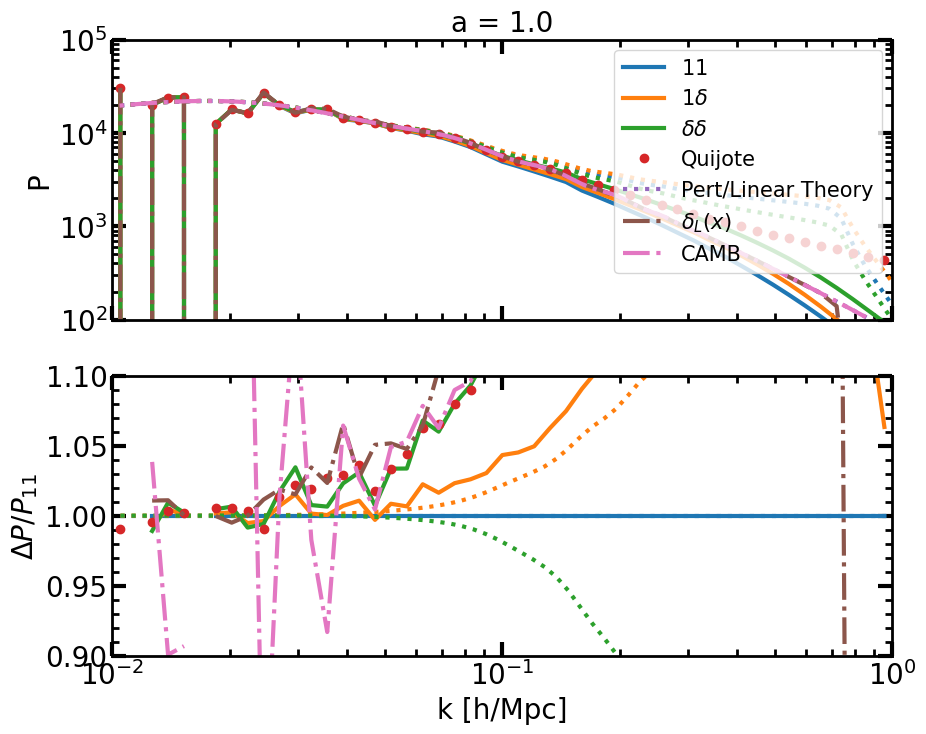

In [163]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].set_title("a = {0:.2}".format(sim.header["Time"]))

for i in [0,1,5]:
    c=ax[0].loglog(pk[i]['k'], pk[i]['pk'], label=labels_pt[i])
    ax[0].loglog(lt_k, pk_pt[i],ls=':', color=c[0].get_color())

    ax[1].semilogx(pk[i]['k'], pk[i]['pk']/pk[0]['pk'], label=labels_pt[i], c=c[0].get_color())
    ax[1].plot(lt_k, pk_pt[i]/pk_pt[0],ls=':', color=c[0].get_color())

c=ax[0].loglog(pksim['k'], pksim['pk'], 'o', label="Quijote")
ax[1].plot(pksim['k'], pksim['pk']/pk[0]['pk'], 'o', c=c[0].get_color())

ax[0].loglog(pk[i]['k'], sim.Cosmology.get_powerspec(pk[i]['k']), ls=':', label="Pert/Linear Theory")

c=ax[0].loglog(pk_delta['k'], pk_delta['pk']/_ngrid**6, label='$\delta_L(x)$', ls="-.")
ax[1].plot(pk_delta['k'], pk_delta['pk']/_ngrid**6/pk[0]['pk'], ls="-.", c=c[0].get_color())

kk, pk_camb = np.loadtxt("/dipc/reangulo/tmp/663/ICs/Pk_mm_z=0.000.txt", unpack=True)
pk_camb_i = np.exp(np.interp(np.log(pk_delta['k']), np.log(kk), np.log(pk_camb)))


c=ax[0].plot(kk, 0.855273*pk_camb, label="CAMB",ls="-.")
ax[1].plot(pk_delta['k'], 0.855273*pk_camb_i/pk[0]['pk'], ls="-.", c=c[0].get_color())

ax[1].set_xlabel("k [h/Mpc]")
ax[0].set_ylabel("P")
ax[1].set_ylabel("$\Delta P/P_{11}$")

ax[0].legend()
ax[1].set_ylim([0.9,1.1])
ax[0].set_ylim([1e2,1e5])
ax[0].set_xlim([1e-2,1])

In [170]:
beul_HR = bmodel.get_eul_field_terms()

2024-08-16 15:05:43,474 bacco.BiasModel : Computing expansion bias terms in eulerian coords ...
2024-08-16 15:05:43,476 bacco.BiasModel : Memory used: 147.307569152 Gigabytes
2024-08-16 15:05:43,477 bacco.BiasModel : Computing delta_to_tidal_field with 8 threads...
2024-08-16 15:05:43,477 bacco.BiasModel : fttw plan
2024-08-16 15:05:43,478 bacco.BiasModel : Computing linear field ...
2024-08-16 15:05:43,480 bacco.BiasModel : Memory used: 147.307569152 Gigabytes
2024-08-16 15:05:43,481 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-16 15:05:43,487 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-16 15:05:43,493 bacco.cosmo : Warning! 3LPT growth factor (3a) with reps not yet implemented
2024-08-16 15:05:43,494 bacco.cosmo :   Warning! 3LPT growth factor (3b) with reps not yet implemented
2024-08-16 15:05:48,537 bacco.BiasModel : fttw freqs
2024-08-16 15:05:48,539 bacco.BiasModel : tidk freqs
2024-08-16 15:05:52,225 bacco.Bi

In [169]:
beul_LR = bmodel_LR.get_eul_field_terms()

2024-08-16 15:04:40,957 bacco.BiasModel : Computing expansion bias terms in eulerian coords ...
2024-08-16 15:04:40,959 bacco.BiasModel : Memory used: 144.084967424 Gigabytes
2024-08-16 15:04:40,960 bacco.BiasModel : Computing delta_to_tidal_field with 8 threads...
2024-08-16 15:04:40,961 bacco.BiasModel : fttw plan
2024-08-16 15:04:40,961 bacco.BiasModel : Computing linear field ...
2024-08-16 15:04:40,963 bacco.BiasModel : Memory used: 144.084967424 Gigabytes
2024-08-16 15:04:40,964 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-16 15:04:40,971 bacco.cosmo : Warning! 2LPT growth factor with reps not yet implemented
2024-08-16 15:04:40,977 bacco.cosmo : Warning! 3LPT growth factor (3a) with reps not yet implemented
2024-08-16 15:04:40,978 bacco.cosmo :   Warning! 3LPT growth factor (3b) with reps not yet implemented
2024-08-16 15:04:46,082 bacco.BiasModel : fttw freqs
2024-08-16 15:04:46,083 bacco.BiasModel : tidk freqs
2024-08-16 15:04:50,699 bacco.Bi

r : Counting modes
bacco.power : done counting modes in 0.387931 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000175 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass -4.85555e-07 (grid1) -1.88078e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.453252 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.391205 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000171 secs
bacco.power : Deallocating arrays
bacco.power : boxsize 1000.000000; ngrid 512; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolv

2024-08-16 15:05:39,894 bacco.statistics :  mesh done in 1.62 s
2024-08-16 15:05:39,896 bacco.BiasModel : mesh #3
2024-08-16 15:05:39,896 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 15:05:39,897 bacco.statistics : starting deposit 1
2024-08-16 15:05:41,512 bacco.statistics :  mesh done in 1.62 s
2024-08-16 15:05:41,514 bacco.BiasModel : mesh #4
2024-08-16 15:05:41,515 bacco.statistics : Computing cic mesh with ngrid=512 and interlacing=False
2024-08-16 15:05:41,515 bacco.statistics : starting deposit 1
2024-08-16 15:05:43,129 bacco.statistics :  mesh done in 1.61 s


In [184]:
np.array(beul_HR).shape

(5, 1, 512, 512, 512)

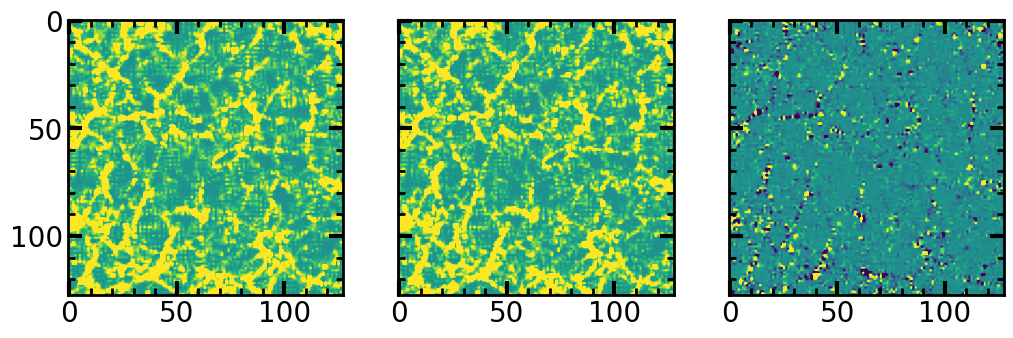

In [217]:
fig, ax = plt.subplots(1,3, figsize=(12,5),sharex=True,sharey=True)
findex = 0
npix=128
ax[0].imshow(beul_LR[findex][0,:npix,:npix,0],vmin=-1,vmax=1)
ax[1].imshow(beul_HR[findex][0,:npix,:npix,0],vmin=-1,vmax=1)
ax[2].imshow(beul_HR[findex][0,:npix,:npix,0]-beul_LR[findex][0,:npix,:npix,0],vmin=-1,vmax=1)


In [189]:
dx= (beul_HR[1][0,:,:,:]-beul_LR[1][0,:,:,:]).flatten()

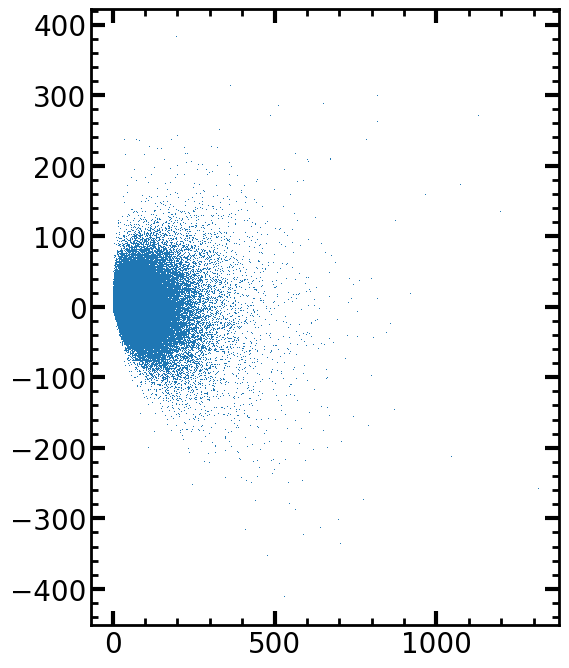

In [211]:
plt.plot(beul_LR[0].flatten(),dx,',')

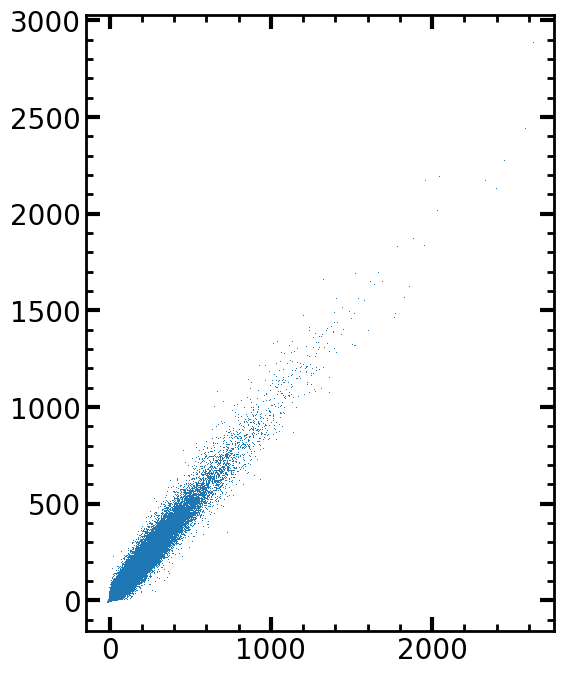

In [213]:
plt.plot(beul_HR[1][0,:,:,:].flatten(),beul_LR[1][0,:,:,:].flatten(),',')